# Interpolación Espacial
---


In [1]:
from google.cloud import storage
from graphcast import checkpoint
from graphcast import graphcast
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
# Importamos paquete local
import sys, os
sys.path.append(os.path.dirname(os.getcwd()) + '\\src')
from art1_tools import interpolation

In [3]:
# Crear un cliente de Google Cloud Storage anónimo.
gcs_client = storage.Client.create_anonymous_client()

# Obtener el bucket "dm_graphcast" del cliente de Google Cloud Storage.
gcs_bucket = gcs_client.get_bucket("dm_graphcast")

In [4]:
# Obtener la fuente seleccionada en las pestañas de selección.
params_file = 'GraphCast_operational - ERA5-HRES 1979-2021 - resolution 0.25 - pressure levels 13 - mesh 2to6 - precipitation output only.npz'
# Cargar los parámetros del archivo seleccionado.
with gcs_bucket.blob(f"params/{params_file}").open("rb") as f:
    ckpt = checkpoint.load(f, graphcast.CheckPoint)
params = ckpt.params
state = {}

model_config = ckpt.model_config
task_config = ckpt.task_config

In [5]:
def data_valid_for_model(
        file_name: str, model_config: graphcast.ModelConfig, task_config: graphcast.TaskConfig):
    """
    Verificar si los datos del archivo son válidos para el modelo y la tarea configurados.

    Args:
        file_name (str): El nombre del archivo de datos.
        model_config (graphcast.ModelConfig): La configuración del modelo.
        task_config (graphcast.TaskConfig): La configuración de la tarea.

    Returns:
        bool: True si los datos son válidos para el modelo y la tarea configurados, False de lo contrario.

    """
    file_parts = parse_file_parts(file_name.removesuffix(".nc"))
    return (
        model_config.resolution in (0, float(file_parts["res"])) and
        len(task_config.pressure_levels) == int(file_parts["levels"]) and
        (
            ("total_precipitation_6hr" in task_config.input_variables and
             file_parts["source"] in ("era5", "fake")) or
            ("total_precipitation_6hr" not in task_config.input_variables and
             file_parts["source"] in ("hres", "fake"))
        )
    )

In [6]:
def parse_file_parts(file_name):
    """
    Parse a file name into parts separated by underscores and hyphens.

    Args:
        file_name (str): The name of the file to parse.

    Returns:
        dict: A dictionary containing the parsed parts of the file name. The keys are the parts before the first hyphen,
              and the values are the parts after the first hyphen in each section of the file name.

    Example:
        >>> parse_file_parts("example_part1-part2_part3-part4.txt")
        {'example_part1': 'part2', 'part3': 'part4'}
    """
    return dict(part.split("-", 1) for part in file_name.split("_"))

In [7]:
# Cargar datos meteorológicos
dataset_file = 'source-hres_date-2022-01-01_res-0.25_levels-13_steps-12.nc'

# Verificar si el archivo de conjunto de datos es válido para el modelo y la tarea configurados.
if not data_valid_for_model(dataset_file, model_config, task_config):
    raise ValueError(
        "Archivo de conjunto de datos no válido, vuelva a ejecutar la celda anterior y elija un archivo de conjunto de datos válido.")

# Cargar el conjunto de datos meteorológicos desde el archivo seleccionado.
with gcs_bucket.blob(f"dataset/{dataset_file}").open("rb") as f:
    example_batch = xr.load_dataset(f).compute()

# Asegurarse de que el conjunto de datos tenga al menos 3 dimensiones de tiempo (2 para entrada, al menos 1 para objetivos).
assert example_batch.dims["time"] >= 3  

# Imprimir información sobre el archivo de conjunto de datos seleccionado.
print(", ".join([f"{k}: {v}" for k, v in parse_file_parts(
    dataset_file.removesuffix(".nc")).items()]))

# Mostrar el conjunto de datos cargado.
example_batch

c:\Users\gcuervo\miniconda3\envs\art1_pyenv\Lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.23.0
  warnings.warn(


source: hres, date: 2022-01-01, res: 0.25, levels: 13, steps: 12


<xarray.Dataset>
Dimensions:                       (lon: 1440, lat: 721, time: 14, level: 13,
                                   batch: 1)
Coordinates:
  * lon                           (lon) float32 0.0 0.25 0.5 ... 359.5 359.8
  * lat                           (lat) float32 -90.0 -89.75 ... 89.75 90.0
  * time                          (time) timedelta64[ns] 0 days 00:00:00 ... ...
  * level                         (level) int32 50 100 150 200 ... 850 925 1000
    datetime                      (batch, time) datetime64[ns] 2022-01-01 ......
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 2.735e+04 ... -0.07617
    land_sea_mask                 (lat, lon) float32 1.0 1.0 1.0 ... 0.0 0.0 0.0
    2m_temperature                (batch, time, lat, lon) float32 250.3 ... 2...
    mean_sea_level_pressure       (batch, time, lat, lon) float32 9.936e+04 ....
    10m_v_component_of_wind       (batch, time, lat, lon) float32 -0.4746 ......
    10m_u_component_of_wind       (batch, time, lat, lon) float32 -5.817 ... ...
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float32 238....
    geopotential                  (batch, time, level, lat, lon) float32 1.98...
    u_component_of_wind           (batch, time, level, lat, lon) float32 0.00...
    v_component_of_wind           (batch, time, level, lat, lon) float32 -0.0...
    vertical_velocity             (batch, time, level, lat, lon) float32 -0.0...
    specific_humidity             (batch, time, level, lat, lon) float32 3.02...

## Recorte de la zona
---

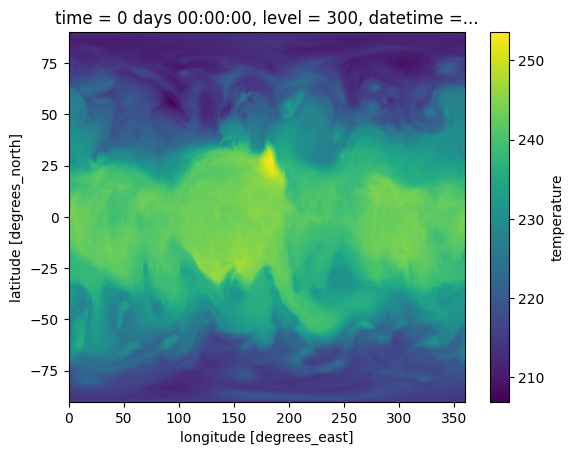

In [8]:
example_batch.isel(batch=0).isel(level=5).isel(time=0)["temperature"].plot()

In [9]:
clip_map = example_batch.sel(lat=slice(19.55, 34.6), lon=slice(180-34.45, 180-4.5))
clip_map

<xarray.Dataset>
Dimensions:                       (lon: 120, lat: 60, time: 14, level: 13,
                                   batch: 1)
Coordinates:
  * lon                           (lon) float32 145.8 146.0 ... 175.2 175.5
  * lat                           (lat) float32 19.75 20.0 20.25 ... 34.25 34.5
  * time                          (time) timedelta64[ns] 0 days 00:00:00 ... ...
  * level                         (level) int32 50 100 150 200 ... 850 925 1000
    datetime                      (batch, time) datetime64[ns] 2022-01-01 ......
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 -0.9746 -4.566 ... -1.873
    land_sea_mask                 (lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    2m_temperature                (batch, time, lat, lon) float32 298.1 ... 2...
    mean_sea_level_pressure       (batch, time, lat, lon) float32 1.017e+05 ....
    10m_v_component_of_wind       (batch, time, lat, lon) float32 -9.008 ... ...
    10m_u_component_of_wind       (batch, time, lat, lon) float32 -0.7359 ......
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float32 205....
    geopotential                  (batch, time, level, lat, lon) float32 2.01...
    u_component_of_wind           (batch, time, level, lat, lon) float32 1.61...
    v_component_of_wind           (batch, time, level, lat, lon) float32 2.89...
    vertical_velocity             (batch, time, level, lat, lon) float32 0.02...
    specific_humidity             (batch, time, level, lat, lon) float32 2.99...

In [10]:
clip_map.dims

Frozen({'lon': 120, 'lat': 60, 'time': 14, 'level': 13, 'batch': 1})

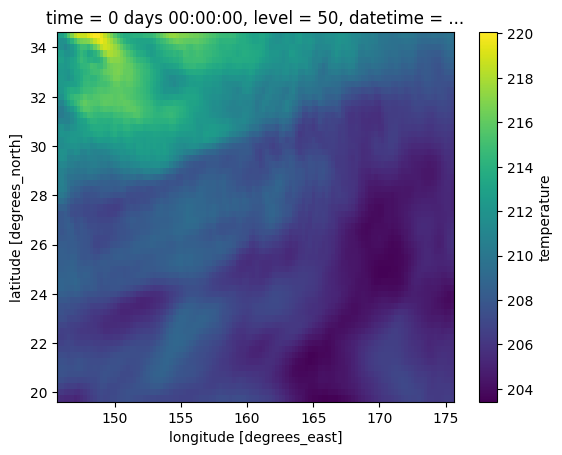

In [11]:
im1 = clip_map.isel(batch=0).isel(level=0).isel(time=0)["temperature"]
im1.plot()

## Resolución (interpolación)
---

In [12]:
clip_map_360x181 = interpolation.resize_lonxlat(clip_map, (360, 181))
clip_map_360x181

<xarray.Dataset>
Dimensions:                       (lat: 181, lon: 360, time: 14, level: 13,
                                   batch: 1)
Coordinates:
  * time                          (time) timedelta64[ns] 0 days 00:00:00 ... ...
  * level                         (level) int32 50 100 150 200 ... 850 925 1000
    datetime                      (batch, time) datetime64[ns] 2022-01-01 ......
  * lon                           (lon) float64 145.8 145.8 ... 175.4 175.5
  * lat                           (lat) float64 19.75 19.83 19.91 ... 34.42 34.5
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float64 -0.9746 -4.065 ... -1.873
    land_sea_mask                 (lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    2m_temperature                (batch, time, lat, lon) float64 298.1 ... 2...
    mean_sea_level_pressure       (batch, time, lat, lon) float64 1.017e+05 ....
    10m_v_component_of_wind       (batch, time, lat, lon) float64 -9.008 ... ...
    10m_u_component_of_wind       (batch, time, lat, lon) float64 -0.7359 ......
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float64 205....
    geopotential                  (batch, time, level, lat, lon) float64 2.01...
    u_component_of_wind           (batch, time, level, lat, lon) float64 1.61...
    v_component_of_wind           (batch, time, level, lat, lon) float64 2.89...
    vertical_velocity             (batch, time, level, lat, lon) float64 0.02...
    specific_humidity             (batch, time, level, lat, lon) float64 2.99...

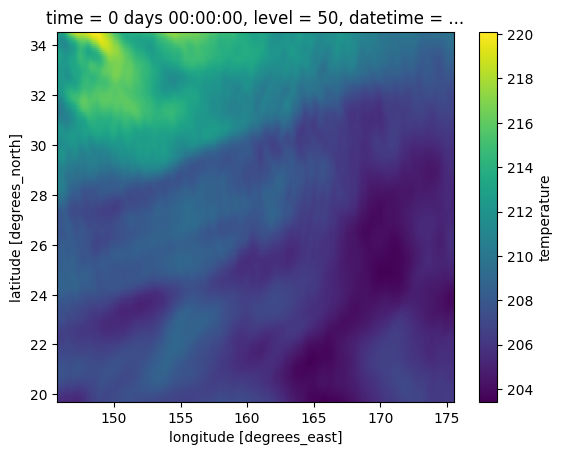

In [13]:
clip_map_360x181.isel(time=0).isel(level=0)["temperature"].plot()

In [14]:
clip_map_360x181.to_netcdf("C:\\Users\\gcuervo\\OneDrive - Universidad de Las Palmas de Gran Canaria\\Documents\\Doctorado\\DB\\GraphCast_data\\" 
                           + "canarias_atmos_360_181.nc")